# The Truck Dataset

The purpose of this notebook is to generate a synthetic dataset of failure times with and without uncensoring to study survival analysis and competing risk analysis methods with access to the ground truth (e.g. uncensored failure times and true hazard functions).

We chose to simulate a predictive maintenance problem, namely the failures during the operation of a fleet of trucks.

### Type of failures

Survival analysis can be used for predictive maintenance in industrial settings. In this work, we will create a synthetic dataset of trucks and drivers with their associated simulated failures, in a competitive events setting. Our truck failures can be of three types:

**1. Initial assembly failures $e_1$**

This failure might occure during the first weeks after the operation of a newly commissioned truck. As these hazards stem from **manufacturing defects** such as incorrect wiring or components assembly, they are dependent on the quality of assembly of each truck, along with its usage rate.

**2. Operation failure $e_2$**

Operation failures can occur on a day to day basis because of some critical mistakes made by the driver —e.g. car accident, wrong gas fill-up. The probability of making mistakes is linked to the ease of use (UX) of the truck, the expertise of the driver and the usage rate of the truck.

**3. Fatigue failure $e_3$**

Fatigue failure relate the wear of the material and components of each truck through time. This type of hazard is linked to the quality of the material of the truck and also its usage rate. I could also be linked to the ability of the driver to operate it with minimal wear and tear (e.g. reduced or anticipated use of breaks, use of gears and smooth accelerations and decelarations).

### Observed and hidden variables
We make the simplistic assumptions that the variables of interest are constant through time. To create non-linearities and make the dataset more challenging, we consider that the observer don't have access to the three truck characteristics: assembly quality, UX and material quality.

Instead, the observer has only access to the **brand** of the truck and its **model**. They also know the **usage rate** because it is linked to the driver planning, and they have access to the **training level** of each drivers.

<img src="variables.png" width="60%">

So, in summary:

|failure id |failure name |associated features         |
|-----------|-------------|----------------------------|
|$e_1$      |assembly     |assembly quality, usage rate|
|$e_2$      |operation    |UX, operator training, usage rate|
|$e_3$      |fatigue      |material quality, usage rate|

## Drivers and truck properties

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

rng = np.random.RandomState(42)

We consider 10,000 pairs (driver, truck) with constant features. The period span on 10 years.

In [2]:
N = 10_000
total_years = 10
total_days = total_years * 365

### Driver training

Across the fleet, 1/3 of drivers have little to no experience, another 1/3 have prior hands-on training and the last 1/3 has had a formal training on all equipments for the handling of emergency situations. We distinguish their skills as:

In [3]:
driver_skills = [.2, .5, .95]

df = pd.DataFrame(
    dict(
        driver_skills=rng.choice(driver_skills, size=N)
    )
)
df.head()

,driver_skills
0,0.95
1,0.20
2,0.95
3,0.95
4,0.20


### Assembly quality

Let's imagine that the assembly quality depends on the supplier brand. There are two brands on the market, Robusta (R) and Cheapz (C). Cheapz is cheaper but has an assembly quality that is less reliable:

$$q_{R}=0.95 \\ q_{C} = 0.30$$

with the assembly quality $q \in [0, 1]$

Let's say that Robusta and Cheapz have an equal share of the market:

In [4]:
q_r, q_c = 0.95, 0.30

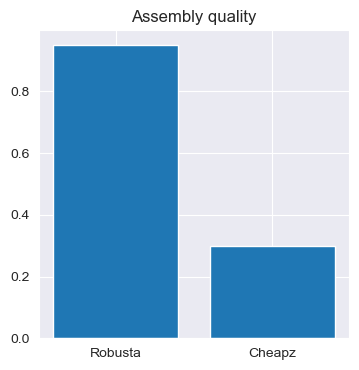

In [5]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.bar(["Robusta", "Cheapz"], height=[q_r, q_c]);
ax.set_title("Assembly quality");

In [6]:
df["brand"] = pd.Series(["Robusta"] * (N//2) + ["Cheapz"] * (N//2))

assembly_quality = np.hstack([
    np.full(shape=N//2, fill_value=q_r),
    np.full(shape=N//2, fill_value=q_c),
])
df["assembly_quality"] = assembly_quality

df.head()

,driver_skills,brand,assembly_quality
0,0.95,Robusta,0.95
1,0.20,Robusta,0.95
2,0.95,Robusta,0.95
3,0.95,Robusta,0.95
4,0.20,Robusta,0.95


### UX

Both brands produce 5 models with similar UX, depending on the year there were designed. Older trucks are often less intuitive and trickier to use, so the UX is improving for each new generation.

$$
\mathrm{UX}_{1}=0.2 \\
\mathrm{UX}_{2}=0.5 \\
\mathrm{UX}_{3}=0.7 \\
\mathrm{UX}_{4}=0.9 \\
\mathrm{UX}_{5}=1.0 \\
$$

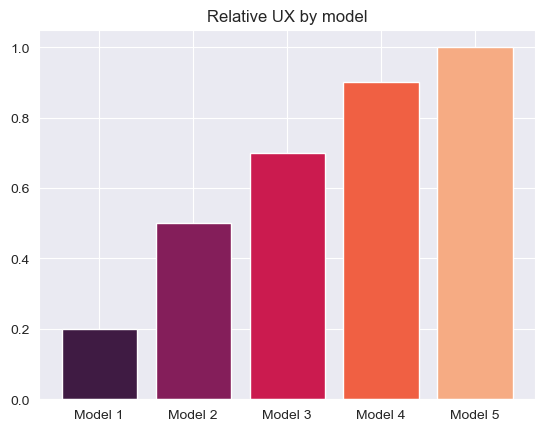

In [7]:
ux_levels = [.2, .5, .7, .9, 1.0]
labels = [f"Model {idx}" for idx in range(1, len(ux_levels)+1)]
ux_models = dict(zip(ux_levels, labels))

fig, ax = plt.subplots()
palette = sns.color_palette("rocket", n_colors=5)
ax.bar(labels, height=ux_levels, color=palette);
plt.title("Relative UX by model");

In [8]:
ux = rng.choice(ux_levels, size=N)
df["model_id"] = pd.Series(ux).map(ux_models)
df["ux"] = ux
df.head()

,driver_skills,brand,assembly_quality,model_id,ux
0,0.95,Robusta,0.95,Model 2,0.5
1,0.20,Robusta,0.95,Model 2,0.5
2,0.95,Robusta,0.95,Model 4,0.9
3,0.95,Robusta,0.95,Model 1,0.2
4,0.20,Robusta,0.95,Model 2,0.5


### Material quality

Both brands also use similar alloys and plastics, however newer machines are often built with cheaper components, so that the more recent the model, the lower the overall material quality:

$$
m_1 = 0.95 \\
m_2 = 0.92 \\
m_3 = 0.90 \\
m_4 = 0.88 \\
m_5 = 0.85 \\
$$

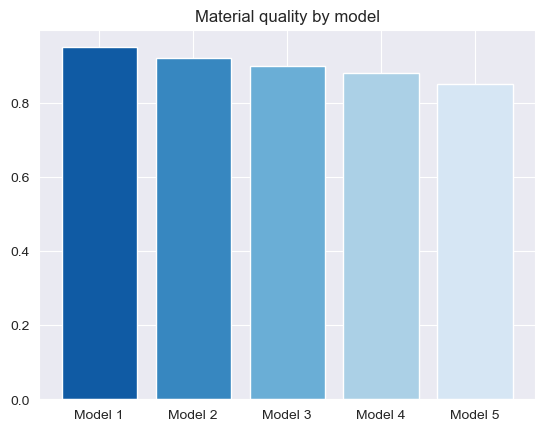

In [9]:
material_quality = [.95, .92, .90, .88, .85]
material_models = dict(zip(labels, material_quality))

fig, ax = plt.subplots()
palette = sns.color_palette("Blues", n_colors=5)[::-1]
ax.bar(labels, height=material_quality, color=palette)
ax.set_title("Material quality by model");

In [10]:
df["materials"] = df["model_id"].map(material_models)
df.head()

,driver_skills,brand,assembly_quality,model_id,ux,materials
0,0.95,Robusta,0.95,Model 2,0.5,0.92
1,0.20,Robusta,0.95,Model 2,0.5,0.92
2,0.95,Robusta,0.95,Model 4,0.9,0.88
3,0.95,Robusta,0.95,Model 1,0.2,0.95
4,0.20,Robusta,0.95,Model 2,0.5,0.92


### Usage rate

Finally, depending on their position in the production line but independently to their model, each machine has a specific usage rate, that will linearly impact each of the 3 hazards. We can imagine a bimodal distribution of the usage, with some machines being used almost continuously while some others are used in batches.

$$
u_1 \sim \mathcal{N}(0.3, 0.05) \\
u_2 \sim \mathcal{N}(0.8, 0.08) \\
$$

And then the final random variable is a gaussian mixture of the two:

$$u = \sum_{i=1}^2 \pi_i u_i = \frac{1}{3} u_1 + \frac{2}{3} u_2$$

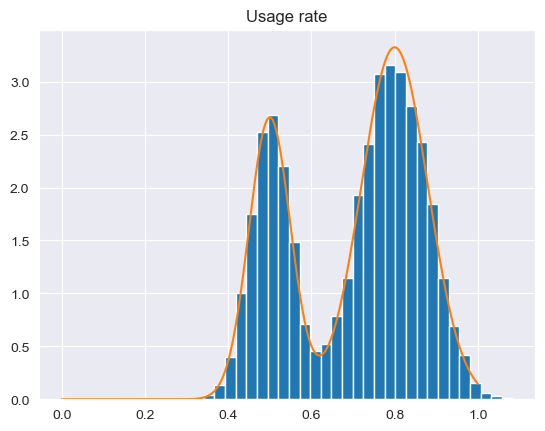

In [11]:
from scipy.stats import norm

u_mu_1, u_sigma_1 = .5, .05
u_mu_2, u_sigma_2 = .8, .08
usage_params = [(u_mu_1, u_sigma_1 ), (u_mu_2, u_sigma_2)]

usage_weights = np.array([1/3, 2/3])
usage_mixture_idxs = rng.choice(len(usage_weights), size=N, p=usage_weights)

usage_rate = np.hstack([
    norm.rvs(*usage_params[idx], random_state=rng)
    for idx in usage_mixture_idxs
])

fig, ax = plt.subplots()
ax.hist(usage_rate, density=True, bins=30)

x = np.linspace(0, 1, N)
usage_rate_pdf = np.zeros(x.shape[0])
for (u_mu, u_sigma), w in zip(usage_params, usage_weights):
    usage_rate_pdf += norm.pdf(x, loc=u_mu, scale=u_sigma) * w

ax.plot(x, usage_rate_pdf)
ax.set_title("Usage rate");

In [12]:
df["usage_rate"] = usage_rate

In [56]:
df

,driver_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_s,e_2_coeff,event,duration
0,0.95,Robusta,0.95,Model 2,0.5,0.92,0.994424,0.497212,0.000517,2,232
1,0.20,Robusta,0.95,Model 2,0.5,0.92,0.727185,0.363593,0.005832,2,243
2,0.95,Robusta,0.95,Model 4,0.9,0.88,0.507999,0.253999,0.000061,3,1747
3,0.95,Robusta,0.95,Model 1,0.2,0.95,0.898196,0.449098,0.000737,2,114
4,0.20,Robusta,0.95,Model 2,0.5,0.92,0.866134,0.433067,0.006946,2,151
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.95,Cheapz,0.30,Model 2,0.5,0.92,0.762000,5.333998,0.000396,1,67
9996,0.20,Cheapz,0.30,Model 4,0.9,0.88,0.721374,5.049620,0.001169,1,154
9997,0.50,Cheapz,0.30,Model 2,0.5,0.92,0.754349,5.280441,0.003787,1,149
9998,0.50,Cheapz,0.30,Model 1,0.2,0.95,0.772335,5.406346,0.006194,1,158


In [59]:
df.sample(frac=1e-3)

,driver_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_s,e_2_coeff,event,duration
1663,0.95,Robusta,0.95,Model 4,0.9,0.88,0.885493,0.442747,0.000106,3,2396
5552,0.20,Cheapz,0.30,Model 5,1.0,0.85,0.887360,6.211517,0.000018,1,97
2025,0.95,Robusta,0.95,Model 5,1.0,0.85,0.795207,0.397604,0.000016,3,2074
9254,0.95,Cheapz,0.30,Model 3,0.7,0.90,0.854846,5.983923,0.000274,1,38
7912,0.20,Cheapz,0.30,Model 4,0.9,0.88,0.901505,6.310538,0.001460,1,8
4644,0.50,Robusta,0.95,Model 1,0.2,0.95,0.570741,0.285371,0.004577,2,165
6073,0.95,Cheapz,0.30,Model 4,0.9,0.88,0.509457,3.566196,0.000061,1,3
6999,0.95,Cheapz,0.30,Model 1,0.2,0.95,0.525356,3.677494,0.000431,1,142
9480,0.50,Cheapz,0.30,Model 2,0.5,0.92,0.443326,3.103279,0.002225,1,622
2097,0.50,Robusta,0.95,Model 4,0.9,0.88,0.591603,0.295801,0.000603,3,2285


## Assembly failure $e_1$

Let $\lambda_1$ be the hazard related to the event $e_1$. We model the $\lambda_1$ with the [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution):

$$f(x, s, k)=\begin{cases}\frac{k}{s}(\frac{x}{s})^{k-1}e^{-(x/s)^k} & \mathrm{if}\; x \geq 0 \\ 0 & \mathrm{o.w.}\end{cases}$$

## TODO: use the Weibull hazard function instead of the PDF!

- k < 1: is good to model manufacturing defects, "infant mortality" and similar, monotonically decreasing hazards;
- k = 1: constant hazards (exponential distribution): random events not related to time (e.g. driving accidents);
- k > 1: "aging" process, wear and tear... monotonically increasing hazards.

In [14]:
def weibull_hazard(t, k=1., s=1., t_shift=0.1):
    # See: https://en.wikipedia.org/wiki/Weibull_distribution
    # t_shift is a trick to avoid avoid negative powers at t=0 when k < 1.
    t = t + t_shift
    return (k / s) * (t / s) ** (k - 1.)

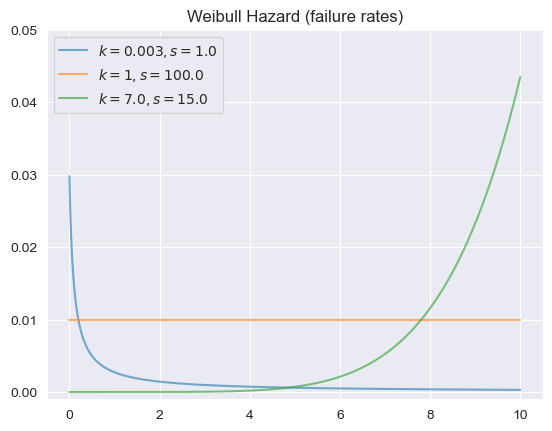

In [15]:
fig, ax = plt.subplots()
hazards_ylim = [-0.001, .05]

t = np.linspace(0, 10., 1000)
for k, s in [(0.003, 1.), (1, 1e2), (7., 15.)]:
    y = weibull_hazard(t, k=k, s=s)
    ax.plot(t, y, alpha=0.6, label=f"$k={k}, s={s}$");
ax.set(
    title="Weibull Hazard (failure rates)",
    ylim=hazards_ylim,
);
plt.legend();

We plot the Weibull distribution for a fix parameter $s$ for different values of $k$:

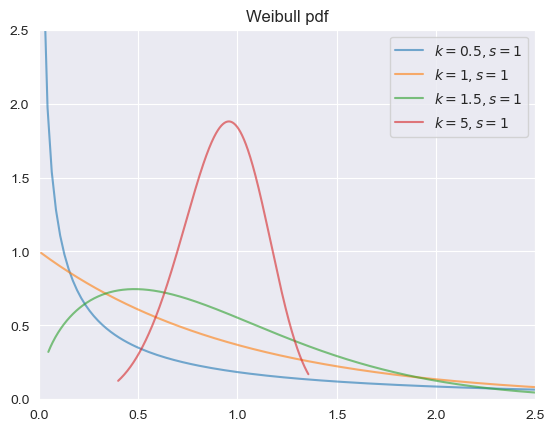

In [16]:
from scipy.stats import weibull_min

fig, ax = plt.subplots()
for k in [.5, 1, 1.5, 5]:
    x = np.linspace(
        weibull_min.ppf(0.01, k),
        weibull_min.ppf(0.99, k),
        1000,
    )
    y = weibull_min.pdf(x, k, loc=0, scale=1)
    ax.plot(x, y, alpha=0.6, label=f"$k={k}, s=1$");
ax.set(
    title="Weibull pdf",
    xlim=[0, 2.5],
    ylim=[0, 2.5],
);
plt.legend();

We plot the Weibull distribution again, this time fixing $k$ and for different $s$:

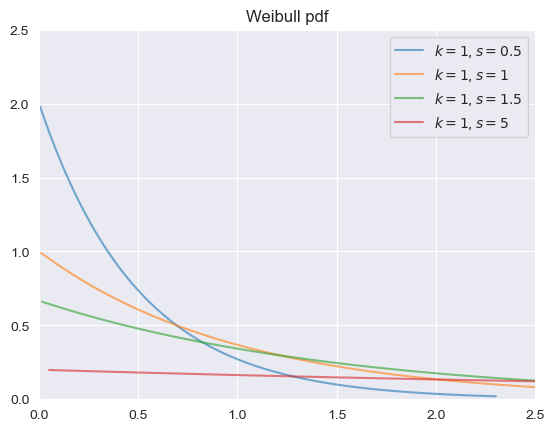

In [17]:
from scipy.stats import weibull_min

k = 1
fig, ax = plt.subplots()
for s in [.5, 1, 1.5, 5]:
    t = np.linspace(
        weibull_min.ppf(0.01, k, scale=s),
        weibull_min.ppf(0.99, k, scale=s),
        1000,
    )
    y = weibull_min.pdf(t, k, loc=0, scale=s)
    ax.plot(t, y, alpha=0.6, label=f"$k={k}, s={s}$");
ax.set(
    title="Weibull pdf",
    xlim=[0, 2.5],
    ylim=[0, 2.5],
);
plt.legend();

This looks like the shape of the hazards we would like to have. So, we need a fix shape parameter $k$ and a scale $\lambda$ that varies according to our couple (truck, driver).

Therefore for the assembly failure $e_1$,
$$s \propto \mathrm{assembly\; quality} \times (1 - \mathrm{usage\; rate})$$
since
$$\lambda_1 \sim \mathrm{Weibull}(s, k)$$

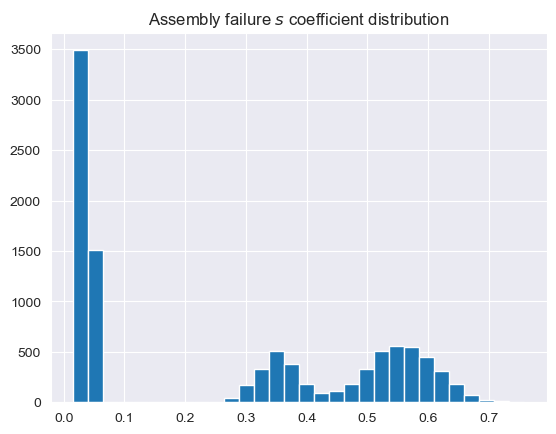

In [138]:
df["e_1_s"] = (1 - df["assembly_quality"]) * df["usage_rate"]
plt.hist(df["e_1_s"], bins=30);
plt.title("Assembly failure $s$ coefficient distribution");

In [139]:
df

,driver_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_s,e_2_coeff,event,duration
0,0.95,Robusta,0.95,Model 2,0.5,0.92,0.994424,0.049721,0.000129,2,757
1,0.20,Robusta,0.95,Model 2,0.5,0.92,0.727185,0.036359,0.001458,2,922
2,0.95,Robusta,0.95,Model 4,0.9,0.88,0.507999,0.025400,0.000015,3,2235
3,0.95,Robusta,0.95,Model 1,0.2,0.95,0.898196,0.044910,0.000184,3,2448
4,0.20,Robusta,0.95,Model 2,0.5,0.92,0.866134,0.043307,0.001737,2,2113
...,...,...,...,...,...,...,...,...,...,...,...
9995,0.95,Cheapz,0.30,Model 2,0.5,0.92,0.762000,0.533400,0.000099,3,1795
9996,0.20,Cheapz,0.30,Model 4,0.9,0.88,0.721374,0.504962,0.000292,3,1981
9997,0.50,Cheapz,0.30,Model 2,0.5,0.92,0.754349,0.528044,0.000947,2,42
9998,0.50,Cheapz,0.30,Model 1,0.2,0.95,0.772335,0.540635,0.001549,2,234


We create a time vector spanning 10 years, binned for each day. We also scale the Weibull distribution by 100 to obtain realistic daily hazards.

In [140]:
df["e_1_s"].values.min()

0.015778664436953246

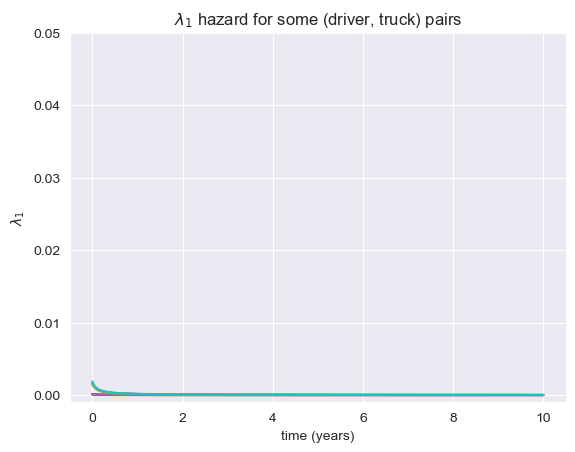

In [141]:
t = np.linspace(0, total_years, total_days)

# hazards_1 = np.vstack([
#     weibull_min.pdf(2*t, 1, loc=0, scale=1) / (800 * l)
#     for l in df["e_1_s"].values
# ])

hazards_1 = np.vstack([
    weibull_hazard(t, k=0.0003, s=1.) * s for s in df["e_1_s"].values
])

fig, ax = plt.subplots()
for hazards_1_ in hazards_1[:5]:
    ax.plot(t, hazards_1_)
for hazards_1_ in hazards_1[-5:]:
    ax.plot(t, hazards_1_)
ax.set(
    title="$\lambda_1$ hazard for some (driver, truck) pairs",
    xlabel="time (years)",
    ylabel="$\lambda_1$",
    ylim=hazards_ylim,
);

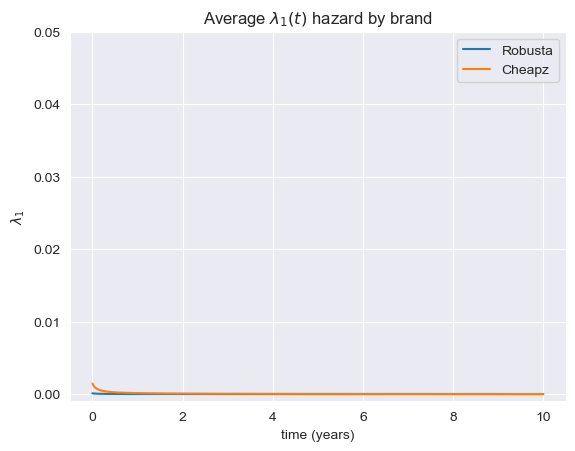

In [142]:
brands = df["brand"].unique()

fig, ax = plt.subplots()
for brand in brands:
    mask_brand = df["brand"] == brand
    mean_hazards = hazards_1[mask_brand].mean(axis=0)
    ax.plot(t, mean_hazards, label=brand)
ax.set(
    title="Average $\lambda_1(t)$ hazard by brand",
    xlabel="time (years)",
    ylabel="$\lambda_1$",
    ylim=hazards_ylim,
)
plt.legend();

## Operation failure $e_2$

We consider the operation hazard to be a constant modulated by driver skills, UX and usage rate.

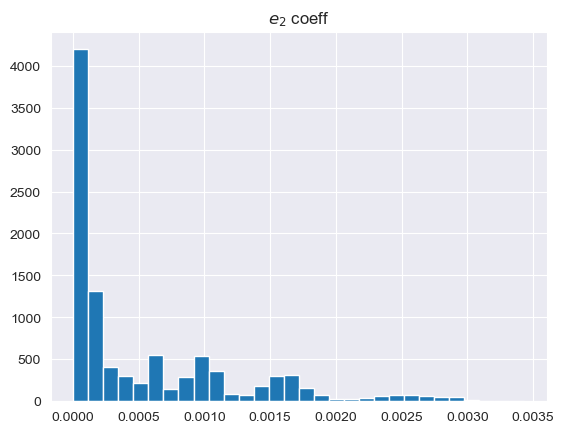

In [143]:
df["e_2_coeff"] = 0.005 * ((1 - df["driver_skills"]) * (1 - df["ux"]) + .001) * df["usage_rate"]
plt.hist(df["e_2_coeff"], bins=30);
plt.title("$e_2$ coeff");

The baseline is one failure every 5 years, which we multiply be the $e_2$ coeff.

In [144]:
e_2_coeff = df["e_2_coeff"]
hazards_2 = np.vstack([
    np.full_like(t, e_2_coeff_)
    for e_2_coeff_ in e_2_coeff
])

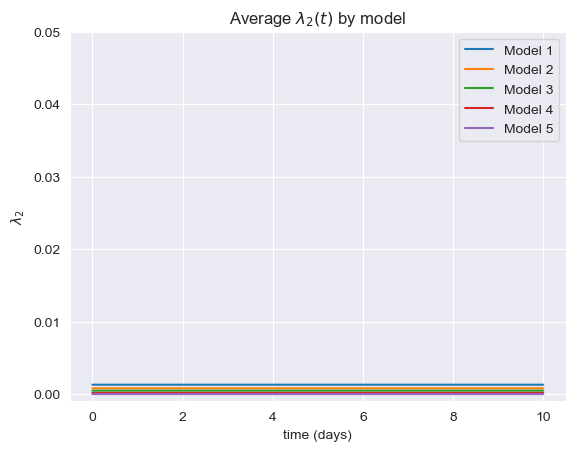

In [145]:
models = sorted(df["model_id"].unique())

fig, ax = plt.subplots()
for model in models:
    mask_model = df["model_id"] == model
    mean_hazards = hazards_2[mask_model].mean(axis=0)
    ax.plot(t, mean_hazards, label=model)
ax.set(
    title="Average $\lambda_2(t)$ by model",
    xlabel="time (days)",
    ylabel="$\lambda_2$",
    ylim=hazards_ylim,
)
plt.legend();

## Fatigue failure $e_3$

Lastly, usage failure start to increase from some $t > t_{fatigue}$, and then plateau at a high probability regime, in a logistic way.

Here, $\lambda_3 \propto (1-\mathrm{materials}) \times \mathrm{usage\; rate}$

In [146]:
def logistic(t, w, offset):
    return 1 / (1 + np.exp((-t + offset) * w))

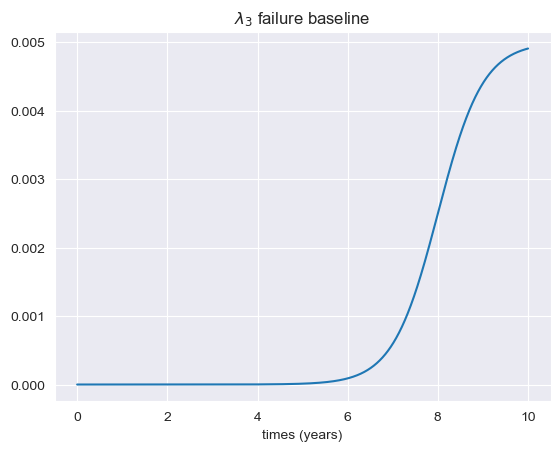

In [147]:
baseline = logistic(t, w=2, offset=8) / 200
plt.plot(t, baseline);
plt.title("$\lambda_3$ failure baseline")
plt.xlabel("times (years)");

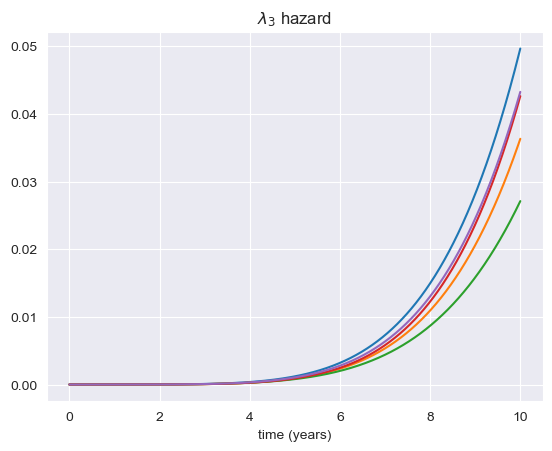

In [148]:
hazards_3 = np.vstack([
    weibull_hazard(t, k=7 * material, s=15.) * rate
    for material, rate in zip(df["materials"], df["usage_rate"])
])

fig, ax = plt.subplots()
for h_3_ in hazards_3[:5]:
    ax.plot(t, h_3_)
ax.set(title="$\lambda_3$ hazard", xlabel="time (years)");

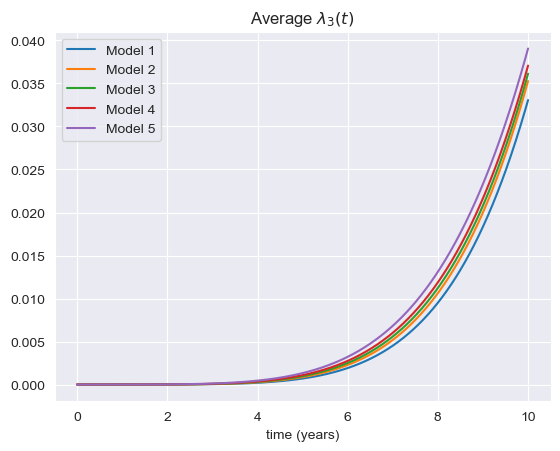

In [149]:
fig, ax = plt.subplots()
for model in models:
    mask_model = df["model_id"] == model
    hazards_mean = hazards_3[mask_model].mean(axis=0)
    ax.plot(t, hazards_mean, label=model)
ax.set(
    title="Average $\lambda_3(t)$",
    xlabel="time (years)",
)
plt.legend();

## Additive hazard curve (any event curve)

Let's enhance our understanding of these hazards by plotting the additive (any event) hazards for some couple (operator, machine).

In [150]:
hazards_1.shape, hazards_2.shape, hazards_3.shape

((10000, 3650), (10000, 3650), (10000, 3650))

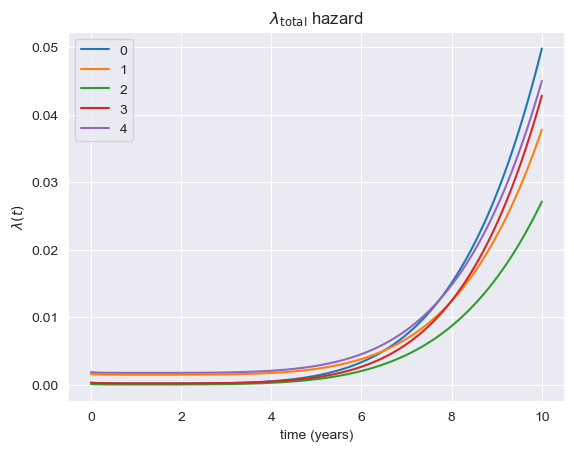

In [151]:
total_hazards = (hazards_1[:5] + hazards_2[:5] + hazards_3[:5])
fig, ax = plt.subplots()
for idx, total_hazards_ in enumerate(total_hazards):
    ax.plot(t, total_hazards_, label=idx)
ax.set(
    title="$\lambda_{\mathrm{total}}$ hazard",
    xlabel="time (years)",
    ylabel="$\lambda(t)$"
)
plt.legend();

## Sampling from all hazards

Now that we have the event probability density for the entire period of observation, we can sample the failure for all (operator, machine) couples and define our target.

Our target `y` is comprised of two columns:
- `event`: 1, 2, 3 or 0 if no event occured during the period or if the observation was censored
- `duration`: the day when the event or censor was observed

In [152]:
from scipy.stats import bernoulli

def get_event_duration(event_matrix):
    trials = bernoulli.rvs(event_matrix, random_state=rng)
    event = np.any(trials, axis=1)
    duration = np.full(event.shape[0], fill_value=total_days)
    rows, cols = np.where(trials == 1)
    # Some trials might have more than one event,
    # we only keep the first one.
    # ex: trials = [[0, 0, 1, 0, 1]] -> duration = 2
    _, idxs = np.unique(rows, return_index=True)
    duration[event] = cols[idxs]
    return event, duration

In [153]:
event_1, duration_1 = get_event_duration(hazards_1)
print(f"total events: {event_1.sum()}, mean duration: {duration_1[event_1].mean():.2f} days")

total events: 1213, mean duration: 680.13 days


In [154]:
event_2, duration_2 = get_event_duration(hazards_2)
print(f"total events: {event_2.sum()}, mean duration: {duration_2[event_2].mean():.2f} days")

total events: 5155, mean duration: 1038.87 days


In [155]:
event_3, duration_3 = get_event_duration(hazards_3)
print(f"total events: {event_3.sum()}, mean duration: {duration_3[event_3].mean():.2f} days")

total events: 10000, mean duration: 2086.77 days


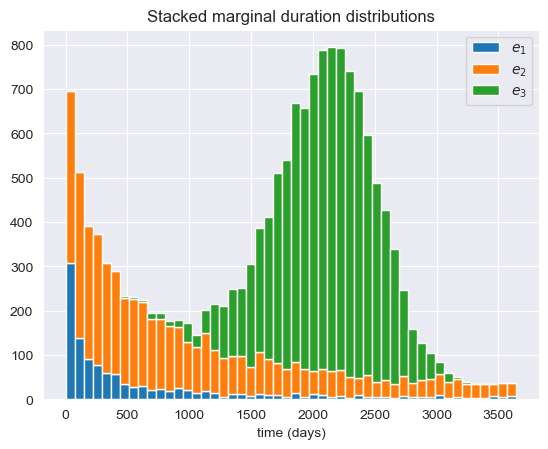

In [156]:
fig, ax = plt.subplots()
hists = [
    duration_1[event_1],
    duration_2[event_2],
    duration_3[event_3],
]
labels = [f"$e_{idx}$" for idx in range(1, 4)]
ax.hist(hists, bins=50, stacked=True, label=labels)
ax.set(
    title="Stacked marginal duration distributions",
    xlabel="time (days)",
)
plt.legend();

We can now build our any event target, which is an `OR` operation on all events.

In [157]:
any_event = np.logical_or(
    np.logical_or(
        event_1,
        event_2,
    ),
    event_3,
)
np.unique(any_event, return_counts=True)

(array([ True]), array([10000]))

For each couple (operator, machine), we only consider the first event that happened, if any. Indeed, if a machine failed from $e_2$, it won't fail for $e_3$.

In [158]:
stacked_durations = np.vstack([duration_1, duration_2, duration_3])
stacked_durations

array([[3650, 3650, 3650, ..., 3650,  172,  450],
       [2286,  671, 3650, ...,  389,  325, 3650],
       [2069, 1646, 2387, ..., 2503, 2373, 1842]])

In [159]:
def get_first_event_duration(any_event, stacked_durations):
    duration_event = stacked_durations[:, any_event]
    first_hit = np.nanargmin(duration_event, axis=0)
    
    n_total = any_event.shape[0]
    n_events = duration_event.shape[1]

    duration = np.full(n_total, fill_value=total_days)
    jdxs = np.arange(n_events)

    duration[any_event] = duration_event[first_hit, jdxs]
    
    event = any_event.astype(int)
    event[np.where(event)] = first_hit + 1

    return event, duration

In [160]:
df["event"], df["duration"] = get_first_event_duration(any_event, stacked_durations)

In [161]:
observed_variables_and_target = [
    "driver_skills",
    "brand",
    "model_id",
    "usage_rate",
    "duration",
    "event",
]
df[observed_variables_and_target]

,driver_skills,brand,model_id,usage_rate,duration,event
0,0.95,Robusta,Model 2,0.994424,2069,3
1,0.20,Robusta,Model 2,0.727185,671,2
2,0.95,Robusta,Model 4,0.507999,2387,3
3,0.95,Robusta,Model 1,0.898196,1787,3
4,0.20,Robusta,Model 2,0.866134,510,2
...,...,...,...,...,...,...
9995,0.95,Cheapz,Model 2,0.762000,1962,3
9996,0.20,Cheapz,Model 4,0.721374,2354,3
9997,0.50,Cheapz,Model 2,0.754349,389,2
9998,0.50,Cheapz,Model 1,0.772335,172,1


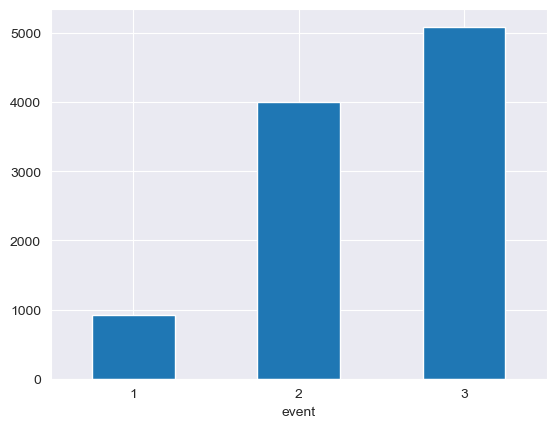

In [162]:
df["event"].value_counts().sort_index().plot.bar(rot=0);

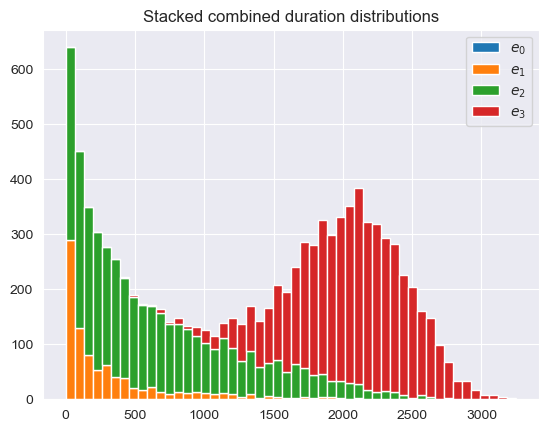

In [163]:
hists = [
    df.loc[df["event"] == idx]["duration"]
    for idx in range(4)
]
labels = [f"$e_{idx}$" for idx in range(4)]
fig, ax = plt.subplots()
ax.hist(hists, bins=50, stacked=True, label=labels);
ax.set(title="Stacked combined duration distributions")
plt.legend();

In [164]:
3000 / 365

8.219178082191782

In [165]:
(
    df[observed_variables_and_target]
    .sample(frac=1)
    .to_parquet("data_truck.parquet", index=False)
)

## Sampling targets at fixed conditional X

We now fix our covariates X to the first truck-driver couple, and create a fixed dataset by sampling $N$ times our first user multi-event hazards. The goal is to check that a non-informative estimator designed for competing events, called Aalen-Johanson, gives hazards estimations close to the ground truth.

In [166]:
df.head(1)

,driver_skills,brand,assembly_quality,model_id,ux,materials,usage_rate,e_1_s,e_2_coeff,event,duration
0,0.95,Robusta,0.95,Model 2,0.5,0.92,0.994424,0.049721,0.000129,3,2069


In [167]:
h_1, h_2, h_3 = hazards_1[0], hazards_2[0], hazards_3[0]
total_h = h_1 + h_2 + h_3
h_1.shape, h_2.shape, h_3.shape

((3650,), (3650,), (3650,))

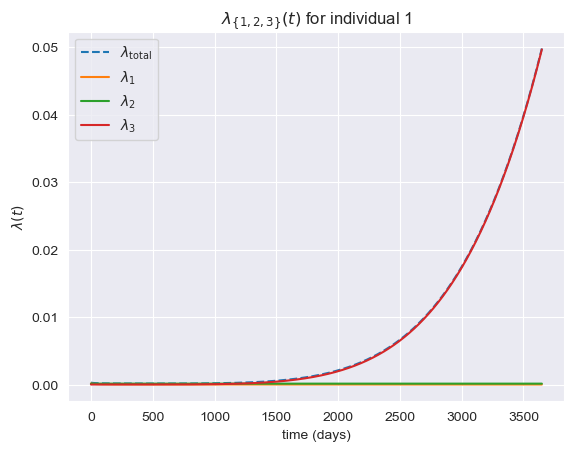

In [168]:
fig, ax = plt.subplots()
ax.plot(total_h, label="$\lambda_{\mathrm{total}}$", linestyle="--")
ax.plot(h_1, label="$\lambda_1$")
ax.plot(h_2, label="$\lambda_2$")
ax.plot(h_3, label="$\lambda_3$")
ax.set(
    title="$\lambda_{\{1,2,3\}}(t)$ for individual 1",
    xlabel="time (days)",
    ylabel="$\lambda(t)$"
);
plt.legend();

We generate $N$ labels by sampling from the hazards of our first truck-driver couple.

In [169]:
def get_labels(hazards):
    """Generate competitive events and durations.
    
    Steps:
    1. Separately sample events and their associated durations
       from the hazards using Bernoulli trials.
    2. Stack durations and compute the binary "any" event.
    3. Fetch the first events based on their durations.
    """
    
    events, durations = [], []
    for hazard_ in hazards:
        hazard_duplicated = np.vstack([hazard_] * N)
        event_, duration_ = get_event_duration(hazard_duplicated)
        events.append(event_)
        durations.append(duration_)
    
    stacked_durations = np.vstack(durations)
    any_event = np.logical_or(
        np.logical_or(
            events[0],
            events[1],
        ),
        events[2],
    )
    
    event, duration = get_first_event_duration(any_event, stacked_durations)
    
    y = pd.DataFrame(
        dict(
            event=event,
            duration=duration,
        )
    )
    return y

In [49]:
all_hazards = [h_1, h_2, h_3]
y_fixed = get_labels(all_hazards)
y_fixed

,event,duration
0,2,138
1,1,717
2,1,983
3,2,207
4,3,2612
...,...,...
9995,2,10
9996,2,1159
9997,3,2042
9998,3,1762


In [50]:
y_fixed["event"].value_counts().sort_index()

event
1    1591
2    5488
3    2921
Name: count, dtype: int64

We begin by estimating the survival probability $\hat{S}(t)=P(t<T)$ of any event of this fixed dataset, using the Kaplan Meier estimator.

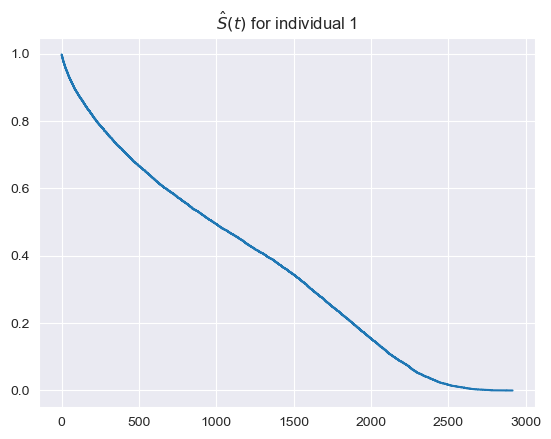

In [51]:
from sksurv.nonparametric import kaplan_meier_estimator

any_event = y_fixed["event"] > 0
km_x, km_y = kaplan_meier_estimator(any_event, y_fixed["duration"])
plt.step(km_x, km_y)
plt.title("$\hat{S}(t)$ for individual 1");

$$CIF(t) = \int^t_0 f(u) du = \int^t_0 \lambda(u).S(u) du $$

Where $f(t)$ is the probability density, $CIF(t)$ is the cumulative incidence function, $\lambda(t)$ is the hazard rate and $S(t)$ is the survival probability.

In [52]:
def hazard_to_cif(hazards, surv_probs):
    return (hazards * surv_probs).cumsum()

The Aalan-Johansen estimator allows us to compute the cumulative incidence function $P(T < t)$ for competitive events.
We compare its estimation to the ground truth by converting our fixed hazards to CIF.

ValueError: x must be within [0.000000; 2915.000000]

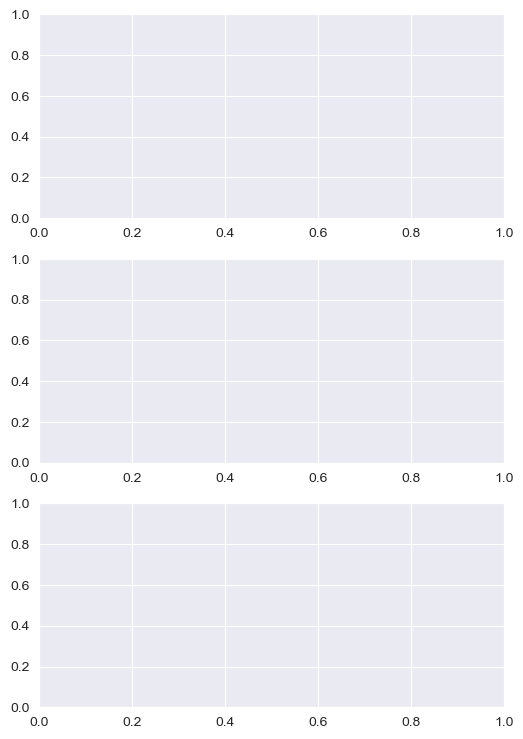

In [53]:
from sksurv.functions import StepFunction
from lifelines import AalenJohansenFitter

fig, axes = plt.subplots(figsize=(6, 9), nrows=3, ncols=1)

# We need to compute the survival proba for any event to
# convert the hazards to CIF.
times = np.arange(total_days)
surv_probs = StepFunction(km_x, km_y)(times)

for event, (ax, hazards) in enumerate(zip(axes, all_hazards), 1):
    ajf = AalenJohansenFitter(calculate_variance=True)
    ajf.fit(y_fixed["duration"], y_fixed["event"], event_of_interest=event)
    ajf.plot(label=f"Predicted $CIF_{event}$", ax=ax)
    
    cif = hazard_to_cif(hazards, surv_probs)
    ax.plot(cif, label=f"True $CIF_{event}$")
    ax.legend()

We see that the Aalan-Johansen estimator gives an accurate representation of the competitive hazards!

Finally, let's save a dataset any event of this fixed covariate. We only keep only events that happened, so that we can add censoring to the dataset while knowing the underlying time-to-event distribution.

In [ ]:
df_single = pd.DataFrame(
    dict(event=any_event, duration=y_fixed["duration"])
)
df_single = (
    df_single.loc[df_single["event"]]
    .reset_index(drop=True)
)
df_single.shape

In [ ]:
df_single["ground_truth_duration"] = df_single["duration"].copy()

censored_duration = np.percentile(df_single["duration"], 70)
mask_censoring = df_single["duration"] > censored_duration

df_single.loc[mask_censoring, "event"] = False
df_single.loc[mask_censoring, "duration"] = censored_duration

df_single["event"].value_counts()

In [ ]:
df_single.to_parquet(
    "data_truck_no_covariates.parquet", index=False,
)